# Blob Detection using Laplacian of Gaussian and Scale-Space Extrema

In [87]:
# Import libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from math import sqrt

## Pre-processing the Image

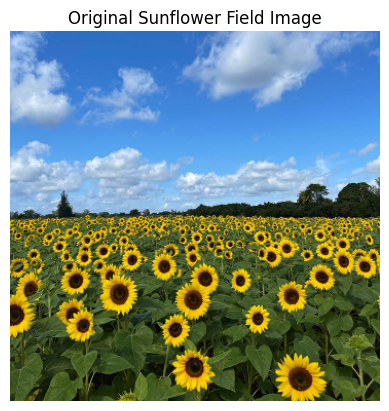

In [88]:
# Load the image
image_sunflower = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_sunflower = cv.cvtColor(image_sunflower, cv.COLOR_BGR2GRAY)

# Display the image
plt.imshow(cv.cvtColor(image_sunflower, cv.COLOR_BGR2RGB))
plt.title("Original Sunflower Field Image")
plt.axis("off")
plt.show()


## Applying Gaussian blur and Laplacian

In [89]:
# Apply Gaussian blur to reduce noise
blurred_sunflower = cv.GaussianBlur(gray_sunflower, (9,9), 0.1)

# Apply Laplacian to detect edges
laplacian_sunflower = cv.Laplacian(blurred_sunflower, cv.CV_64F)


## Detect blobs

In [90]:
# Define parameters for blob detection
min_sigma = 3  # Minimum sigma for LoG
max_sigma = 14  # Maximum sigma for LoG
threshold = 10 # Threshold for blob detection

# Detect blobs using Laplacian of Gaussian
blobs = blob_log(laplacian_sunflower, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)

## Largest circle

In [91]:
# Find the largest circle
max_radius_index = np.argmax(blobs[:, 2])
largest_circle_params = blobs[max_radius_index]
y, x, r = largest_circle_params
print(f"Largest Circle Radius (r): {r}")
print(f"Largest Circle Center (x, y): ({x}, {y})")

Largest Circle Radius (r): 4.222222222222222
Largest Circle Center (x, y): (345.0, 229.0)


## Display blobs on original image

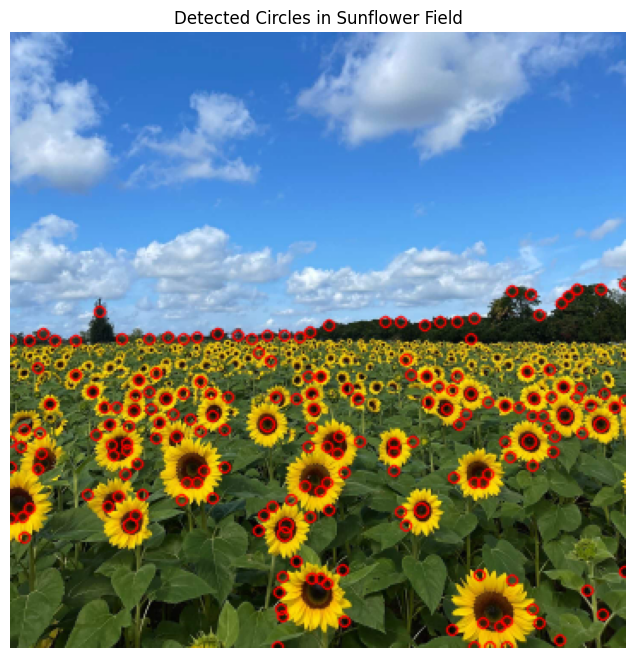

In [92]:
# Draw all detected circles on the original image
for blob in blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(image_sunflower, (int(x), int(y)), int(r), (0, 0, 255), thickness=1, lineType=cv.LINE_AA)  # Red circles

# Display the result using Matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(cv.cvtColor(image_sunflower, cv.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis labels
plt.title('Detected Circles in Sunflower Field')
plt.show()

# Question 2

## Generate the Noisy Point Set (Circle + Line)

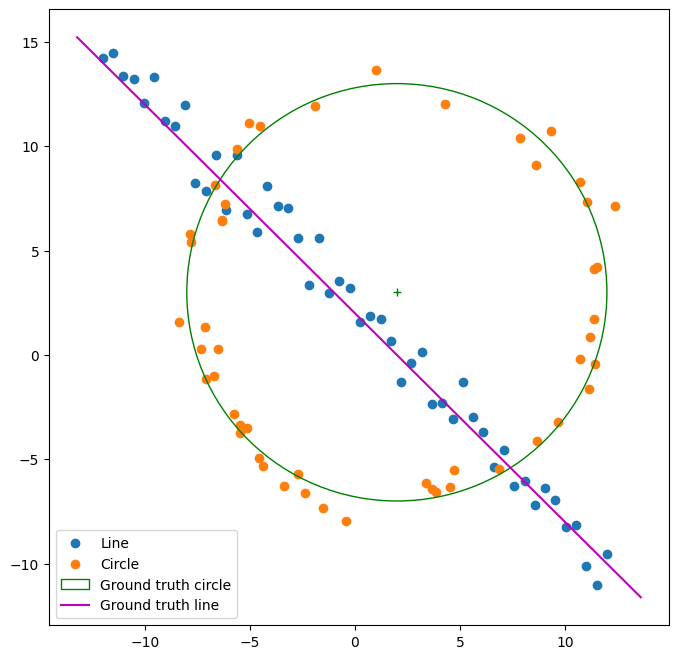

In [93]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
import  circle_fit as cf 

np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

t = np.random.uniform(0, 2*np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)

X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()

## Best line model

In [94]:
import math
from scipy.optimize import minimize
import  circle_fit as cf 

N = X.shape[0]
X_ = X

def line_equation_from_points(x1,y1,x2,y2):    #Calculate the direction vector (del_x,del_y)
    del_x = x2 - x1
    del_y = y2 - y1

    magnitude = math.sqrt(del_x**2 + del_y**2)    #Calculate normalized vactor (a,b)
    a = del_y / magnitude
    b = -del_x / magnitude

    d = (a*x1) + (b*y1)          #Calculate d

    return a,b,d      #return the line equation in the form of ax+ by = d

def line_tls(x , indices):    # RANSAC to fit a line
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

def g(x):                                #Constraint function
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X_,x,t):                 #Computing the consensus (inliers)
    a, b, d = x[0], x[1], x[2]
    error  = np.abs(a*X_[:,0] + b*X_[:,1] - d)
    return error<t

t = 1 #Threshold value to determine data points that are fitted well by model
d = 0.4*N #Number of close data points required to assert that a model fits well to data
s = 2

inliers_line = [] # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = [] # Best model normal to (a,b) and distance from origin d
best_error = np.inf
best_sample_line = [] # Three point sample leading to the best model computation
res_only_with_sample = [] # Result (a,b,d) only using the best sample
best_inliers_line = [] # Inliers using the best sample

while iteration < max_iterations:
    indices = np.random.randint(0,N,s)
    x0 = np.array([1,1,0]) # initial estimate
    res = minimize(fun = line_tls, args=(indices), x0 = x0, tol = 1e-6, constraints=cons, options = {'disp':True})
    inliers_line = consensus_line(X_,res.x,t) #computing inliers
    if inliers_line.sum() > d:
        x0 = res.x
        #computing the new model using all inliers
        res = minimize(fun=line_tls, args=inliers_line, x0 = x0, tol = 1e-6, constraints=cons, options = {'disp':True})
        # print(res.x, res.fun)
        if res.fun < best_error:
            # print("A better model is found ...", res.x, res.fun)
            best_model_line = res.x
            best_error = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1
print("Best line model" , best_model_line)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.123323560816004e-09
            Iterations: 11
            Function evaluations: 49
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0786208103638998e-11
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.975350980935442e-09
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0867735142075082e-07
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4542360058045348e-10
            Iterations: 6
            F

## Implement RANSAC for Line Fitting

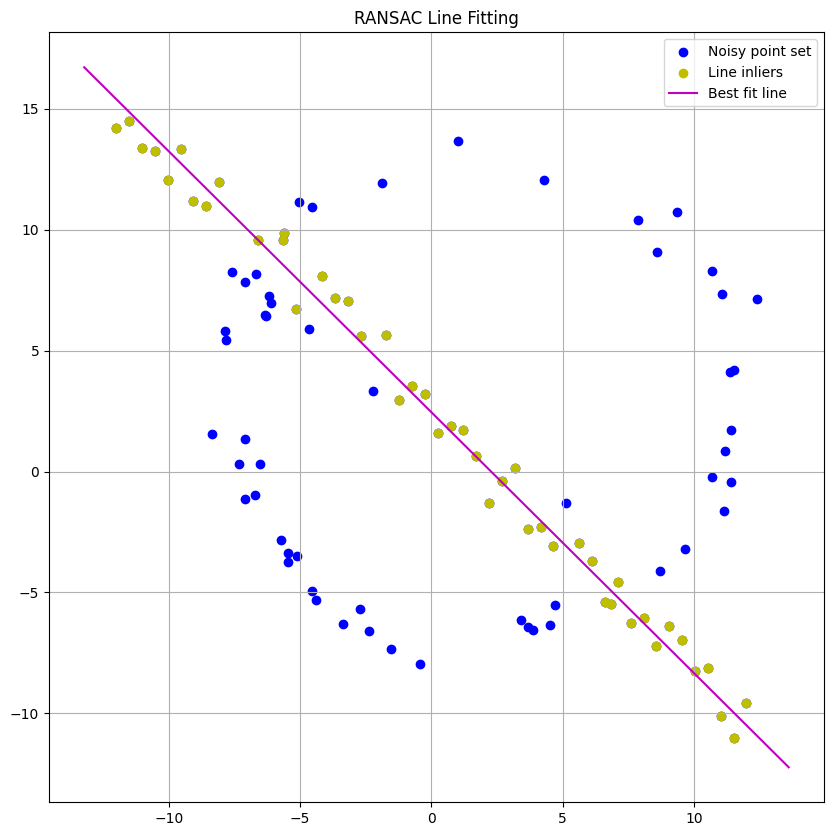

In [95]:
def line_through_points(p1, p2):
    # Calculate normal vector [a, b]⊺
    a = p2[1] - p1[1]
    b = p1[0] - p2[0]
    d = p1[0]*p2[1] - p2[0]*p1[1]  # d is the perpendicular distance from origin

    norm = np.sqrt(a**2 + b**2)
    return a / norm, b / norm, d / norm

def get_line_inliers(a, b, d, X, threshold):
    inliers = []
    for point in X:
        distance = abs(a * point[0] + b * point[1] + d)
        if distance < threshold:
            inliers.append(point)
    return np.array(inliers)

# RANSAC for Line
def ransac_line(X, n_iterations=1000, threshold=1.0, consensus_points=40):
    best_line = None
    best_inliers = []
    best_count = 0
    
    for _ in range(n_iterations):
        # Randomly select 2 points to define a line
        sample_points = X[np.random.choice(X.shape[0], 2, replace=False)]
        
        a, b, d = line_through_points(sample_points[0], sample_points[1])
        
        # Get the inliers for this line
        inliers = get_line_inliers(a, b, d, X, threshold)
        
        # Check if this line has the most inliers
        if len(inliers) > best_count:
            best_line = (a, b, d)
            best_inliers = inliers
            best_count = len(inliers)
    
    return best_line, best_inliers

# Perform RANSAC for line
best_line, best_line_inliers = ransac_line(X, threshold=1.0)

# Plot line inliers
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], color='b', label='Noisy point set')
plt.scatter(best_line_inliers[:, 0], best_line_inliers[:, 1], color='y', label='Line inliers')

# Plot the best line
x_vals = np.array(plt.gca().get_xlim())
y_vals = (-best_line[2] - best_line[0] * x_vals) / best_line[1]
plt.plot(x_vals, y_vals, color='m', label='Best fit line')

plt.title("RANSAC Line Fitting")
plt.legend()
plt.grid()
plt.show()


## Subtract Line Inliers (Remnant)

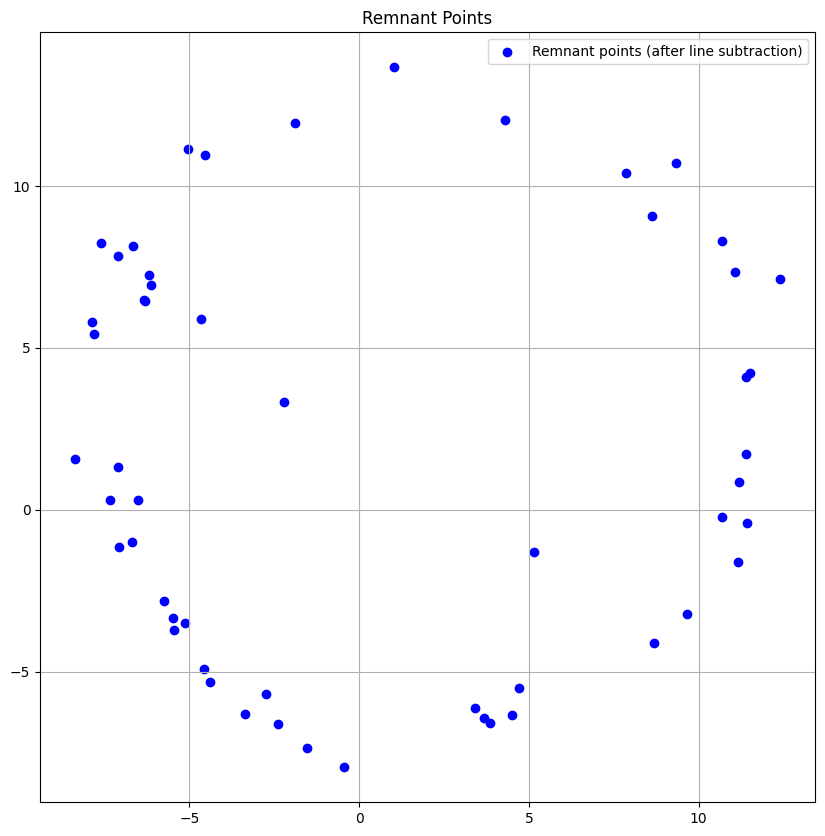

In [97]:
# Remove the line inliers from the dataset (remnant)
remnant = np.array([point for point in X if point.tolist() not in best_line_inliers.tolist()])

# Plot remnant points
plt.figure(figsize=(10, 10))
plt.scatter(remnant[:, 0], remnant[:, 1], color='b', label='Remnant points (after line subtraction)')
plt.title("Remnant Points")
plt.legend()
plt.grid()
plt.show()

## Implement the RANSAC Algorithm for Circle Fitting

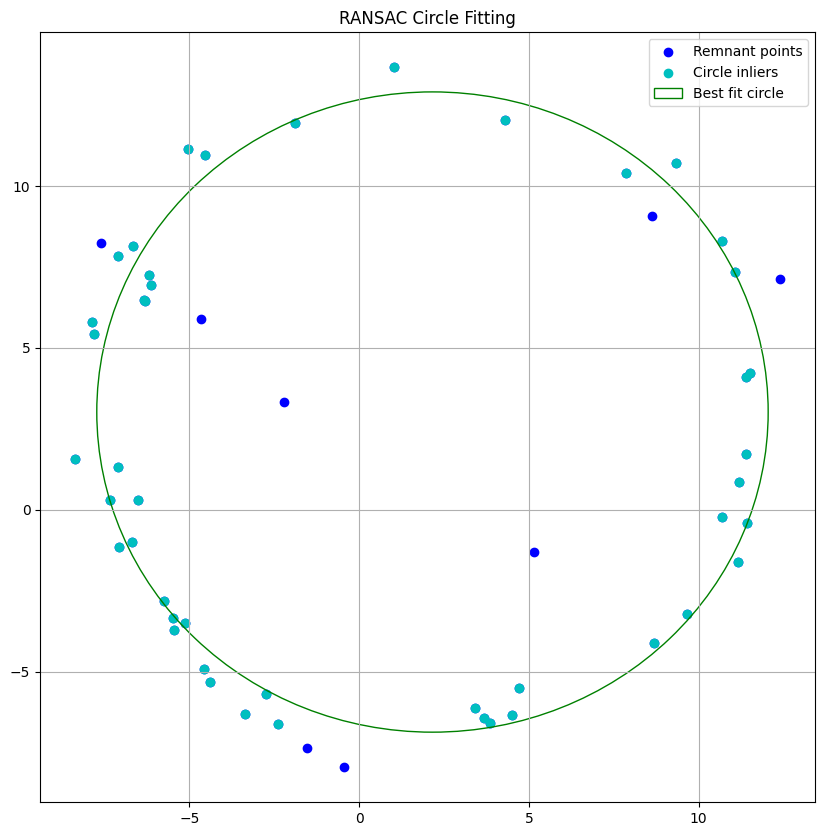

In [98]:
def circle_through_points(p1, p2, p3):
    # Calculate the center and radius of the circle through 3 points
    denominator = 2 * (p1[0] * (p2[1] - p3[1]) + p2[0] * (p3[1] - p1[1]) + p3[0] * (p1[1] - p2[1]))
    
    if denominator == 0:
        return None, None, None
    
    x = ((p1[0]**2 + p1[1]**2) * (p2[1] - p3[1]) + (p2[0]**2 + p2[1]**2) * (p3[1] - p1[1]) + (p3[0]**2 + p3[1]**2) * (p1[1] - p2[1])) / denominator
    y = ((p1[0]**2 + p1[1]**2) * (p3[0] - p2[0]) + (p2[0]**2 + p2[1]**2) * (p1[0] - p3[0]) + (p3[0]**2 + p3[1]**2) * (p2[0] - p1[0])) / denominator
    r = np.sqrt((p1[0] - x)**2 + (p1[1] - y)**2)
    
    return x, y, r

def get_circle_inliers(x, y, r, X, threshold):
    inliers = []
    for point in X:
        distance = np.sqrt((point[0] - x)**2 + (point[1] - y)**2)
        if abs(distance - r) < threshold:
            inliers.append(point)
    return np.array(inliers)

# RANSAC for Circle
def ransac_circle(X, n_iterations=1000, threshold=1.0, consensus_points=60):
    best_circle = None
    best_inliers = []
    best_count = 0
    
    for _ in range(n_iterations):
        # Randomly select 3 points to define a circle
        sample_points = X[np.random.choice(X.shape[0], 3, replace=False)]
        
        x, y, r = circle_through_points(sample_points[0], sample_points[1], sample_points[2])
        
        if x is None:
            continue
        
        # Get the inliers for this circle
        inliers = get_circle_inliers(x, y, r, X, threshold)
        
        # Check if this circle has the most inliers
        if len(inliers) > best_count:
            best_circle = (x, y, r)
            best_inliers = inliers
            best_count = len(inliers)
    
    return best_circle, best_inliers

# Perform RANSAC for circle
best_circle, best_circle_inliers = ransac_circle(remnant, threshold=1.0)

# Plot the remnant points and circle inliers
plt.figure(figsize=(10, 10))
plt.scatter(remnant[:, 0], remnant[:, 1], color='b', label='Remnant points')
plt.scatter(best_circle_inliers[:, 0], best_circle_inliers[:, 1], color='c', label='Circle inliers')

# Plot the best circle
circle_plot = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='g', fill=False, label='Best fit circle')
plt.gca().add_artist(circle_plot)

plt.title("RANSAC Circle Fitting")
plt.legend()
plt.grid()
plt.show()


## Combine All Elements into a Single Plot

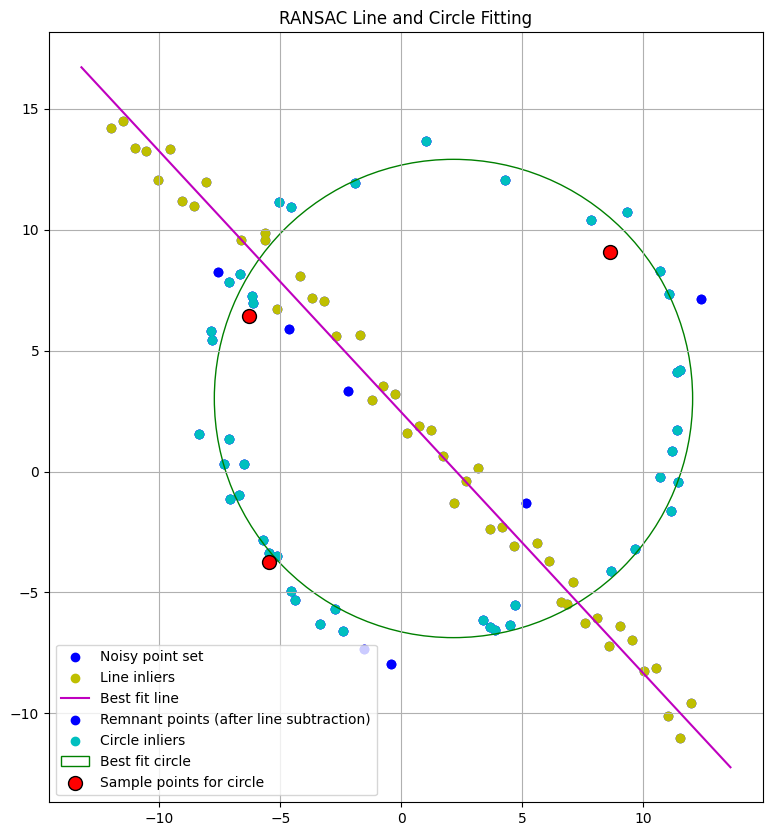

In [99]:
# Combine everything into one plot
plt.figure(figsize=(10, 10))

# Plot the original point set
plt.scatter(X[:, 0], X[:, 1], color='b', label='Noisy point set')

# Plot the line inliers
plt.scatter(best_line_inliers[:, 0], best_line_inliers[:, 1], color='y', label='Line inliers')

# Plot the best-fit line
x_vals = np.array(plt.gca().get_xlim())
y_vals = (-best_line[2] - best_line[0] * x_vals) / best_line[1]
plt.plot(x_vals, y_vals, color='m', label='Best fit line')

# Plot the remnant points (after line inliers are removed)
plt.scatter(remnant[:, 0], remnant[:, 1], color='b', label='Remnant points (after line subtraction)')

# Plot the circle inliers
plt.scatter(best_circle_inliers[:, 0], best_circle_inliers[:, 1], color='c', label='Circle inliers')

# Plot the best-fit circle
circle_plot = plt.Circle((best_circle[0], best_circle[1]), best_circle[2], color='g', fill=False, label='Best fit circle')
plt.gca().add_artist(circle_plot)

# Plot the three points used to estimate the best circle
sample_points = remnant[np.random.choice(remnant.shape[0], 3, replace=False)]
plt.scatter(sample_points[:, 0], sample_points[:, 1], color='r', label='Sample points for circle', marker='o', s=100, edgecolor='black')

# Customize the plot
plt.title("RANSAC Line and Circle Fitting")
plt.legend()
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')

# Show the plot
plt.show()

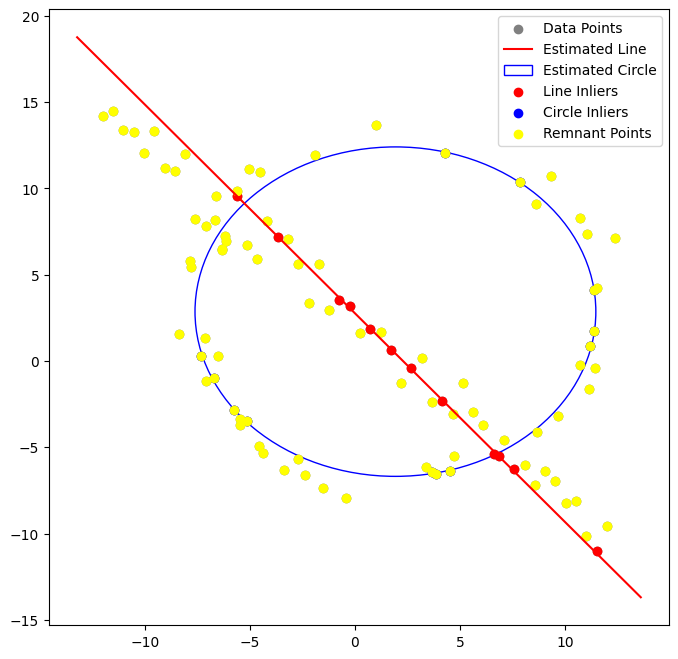

In [83]:
# Plot the original points, the line, the circle, and the inliers
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the original points
ax.scatter(X[:, 0], X[:, 1], color='gray', label='Data Points')

# Plot the RANSAC estimated line
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = -(a * x_ + d) / b
plt.plot(x_, y_, color='red', label='Estimated Line')

# Plot the RANSAC estimated circle
circle_est = plt.Circle((x0, y0), r, color='blue', fill=False, label='Estimated Circle')
ax.add_patch(circle_est)

# Plot the inliers for the line and the circle
ax.scatter(consensus_set[:, 0], consensus_set[:, 1], color='red', label='Line Inliers')
ax.scatter(circle_consensus_set[:, 0], circle_consensus_set[:, 1], color='blue', label='Circle Inliers')

# Highlight the points that led to the best estimates
plt.scatter(remnant_points[:, 0], remnant_points[:, 1], color='yellow', label='Remnant Points')

plt.legend()
plt.show()


## Circle Fitting Using Scipy Optimizer

Estimated circle parameters: x0 = 1.9558666883013833, y0 = 2.987477370370219, r = 9.885603991267367


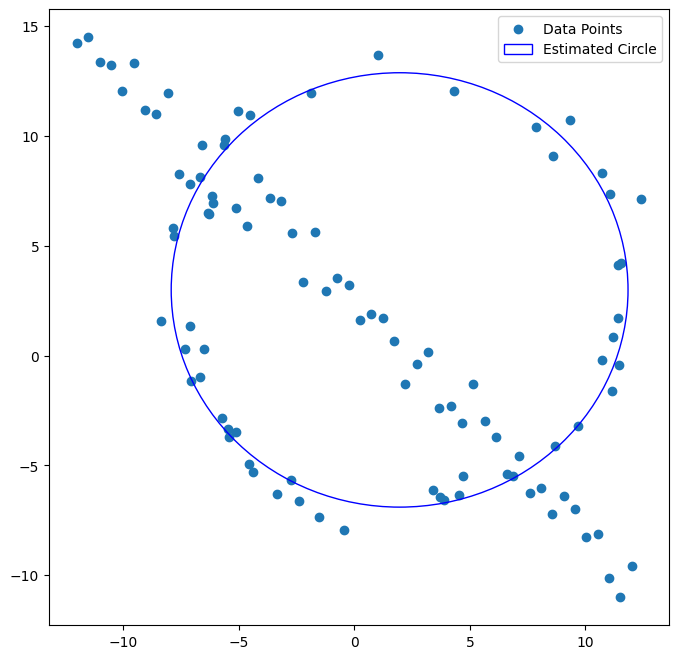

In [84]:
from scipy.optimize import minimize

# Circle fitting error function
def circle_error(params, X):
    x0, y0, r = params
    errors = np.sqrt((X[:, 0] - x0) ** 2 + (X[:, 1] - y0) ** 2) - r
    return np.sum(errors ** 2)

# Initial guess for circle center and radius
initial_guess = [x0_gt, y0_gt, r]

# Use scipy.optimize.minimize to fit the circle
result = minimize(circle_error, initial_guess, args=(X_circ,))
x0_est, y0_est, r_est = result.x

print(f"Estimated circle parameters: x0 = {x0_est}, y0 = {y0_est}, r = {r_est}")

# Plot the estimated circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], label='Data Points')

# Plot the estimated circle
circle_est = plt.Circle((x0_est, y0_est), r_est, color='b', fill=False, label='Estimated Circle')
ax.add_patch(circle_est)

plt.legend()
plt.show()